<a href="https://colab.research.google.com/github/CubeVic/Machine_Learning/blob/main/%5BFreeCodeCamp%5D%5B003%5Dbook_recommendation_knn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Description

**K-Nearest Neighbors**.

This Notebook is using K-Nearest Neighbors to create a book recommendation system

## Dataset
Dataset used [Book-Crossings dataset](http://www2.informatik.uni-freiburg.de/~cziegler/BX/). 

This dataset contains:  

*   1.1 million ratings (scale of 1-10) of 270,000 books by 90,000 users.

In the Nutshell the notes will follow this structure:

## Structure
1.   Clean the data.
2.   Use `NearestNeighbors` from `sklearn.neighbors` to develop a model. This model will provide a book recommendation base in a book input by the user  

> The Nearest Neighbors algorithm measures distance to determine the “closeness” of instances.

The function named `get_recommends` will be the core it takes a book title (from the dataset) as an argument and returns a list of 5 similar books with their distances from the book argument.

## Example

This code:

`get_recommends("The Queen of the Damned (Vampire Chronicles (Paperback))")`

should return:

```
[
  'The Queen of the Damned (Vampire Chronicles (Paperback))',
  [
    ['Catch 22', 0.793983519077301], 
    ['The Witching Hour (Lives of the Mayfair Witches)', 0.7448656558990479], 
    ['Interview with the Vampire', 0.7345068454742432],
    ['The Tale of the Body Thief (Vampire Chronicles (Paperback))', 0.5376338362693787],
    ['The Vampire Lestat (Vampire Chronicles, Book II)', 0.5178412199020386]
  ]
]
```
The output follow this pattern:

*   It is a list
*   First Item: the Book pass in the function
*   Second Item: A list with 5 book recommendation
*   Conten of the Second Item: The Book title, the distance from the recommended book pass in the function.

### (Optional) Recommendation to clean the data

1. remove users with less than 200 ratings.
2. remove books with less than 100 ratings.


# Prepare libraries

**Import libraries**

In [ ]:
# import libraries (you may add additional imports but you may not have to)
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

**Get the Files**

In [ ]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/books/book-crossings.zip

!unzip book-crossings.zip

books_filename = 'BX-Books.csv'
ratings_filename = 'BX-Book-Ratings.csv'

--2020-10-06 07:18:52--  https://cdn.freecodecamp.org/project-data/books/book-crossings.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 104.26.2.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘book-crossings.zip’

book-crossings.zip      [      <=>           ]  24.88M  21.7MB/s    in 1.1s    

2020-10-06 07:18:54 (21.7 MB/s) - ‘book-crossings.zip’ saved [26085508]

Archive:  book-crossings.zip
  inflating: BX-Book-Ratings.csv     
  inflating: BX-Books.csv            
  inflating: BX-Users.csv            


**Import the CSV files**

In [ ]:
# import csv data into dataframes
df_books = pd.read_csv(
    books_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['isbn', 'title', 'author'],
    usecols=['isbn', 'title', 'author'],
    dtype={'isbn': 'str', 'title': 'str', 'author': 'str'})

df_ratings = pd.read_csv(
    ratings_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['user', 'isbn', 'rating'],
    usecols=['user', 'isbn', 'rating'],
    dtype={'user': 'int32', 'isbn': 'str', 'rating': 'float32'})

In [ ]:
# add your code here - consider creating a new cell for each section of code

# Clean the Data

In [ ]:
user_groupby = df_ratings.groupby(by='user').count().rename(columns={'isbn':'Number_ratings'}).drop(columns={'rating'})

In [ ]:
user_groupby[user_groupby['Number_ratings']>200]

,Number_ratings
user,
254,314
2276,498
2766,274
2977,232
3363,901
...,...
275970,1376
277427,497
277478,214


In [ ]:
user_more_200 = user_groupby[user_groupby['Number_ratings']>200] 
user_more_200_values = user_more_200.index.values
user_more_200_values

In [ ]:
df_ratings_more_200 = df_ratings.loc[df_ratings['user'].isin(user_more_200_values)]
df_ratings_more_200

,user,isbn,rating
1456,277427,002542730X,10.0
1457,277427,0026217457,0.0
1458,277427,003008685X,8.0
1459,277427,0030615321,0.0
1460,277427,0060002050,0.0
...,...,...,...
1147612,275970,3829021860,0.0
1147613,275970,4770019572,0.0
1147614,275970,896086097,0.0
1147615,275970,9626340762,8.0


In [ ]:
joined_df = pd.merge(df_ratings_more_200, df_books, on='isbn')
joined_df

,user,isbn,rating,title,author
0,277427,002542730X,10.0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner
1,3363,002542730X,0.0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner
2,11676,002542730X,6.0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner
3,12538,002542730X,10.0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner
4,13552,002542730X,0.0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner
...,...,...,...,...,...
487680,275970,1892145022,0.0,Here Is New York,E. B. White
487681,275970,1931868123,0.0,There's a Porcupine in My Outhouse: Misadventu...,Mike Tougias
487682,275970,3411086211,10.0,Die Biene.,Sybil GrÃ?Â¤fin SchÃ?Â¶nfeldt
487683,275970,3829021860,0.0,The Penis Book,Joseph Cohen


In [ ]:
joined_df_grouped = joined_df.groupby(by='isbn').count().rename(
    columns={'user':'number_book_rating',
             }).drop(columns={'rating','title','author'})

In [ ]:
books_more_100 = joined_df_grouped[joined_df_grouped['number_book_rating']>100]
books_more_100 = books_more_100.index.values
books_more_100

In [ ]:
joined_df.loc[joined_df['isbn'].isin(books_more_100)]

In [ ]:
df_final = joined_df.loc[joined_df['isbn'].isin(books_more_100)]
df_final.groupby(by='isbn').count()
df_final

# Exploring the data

In [ ]:
import seaborn as sns

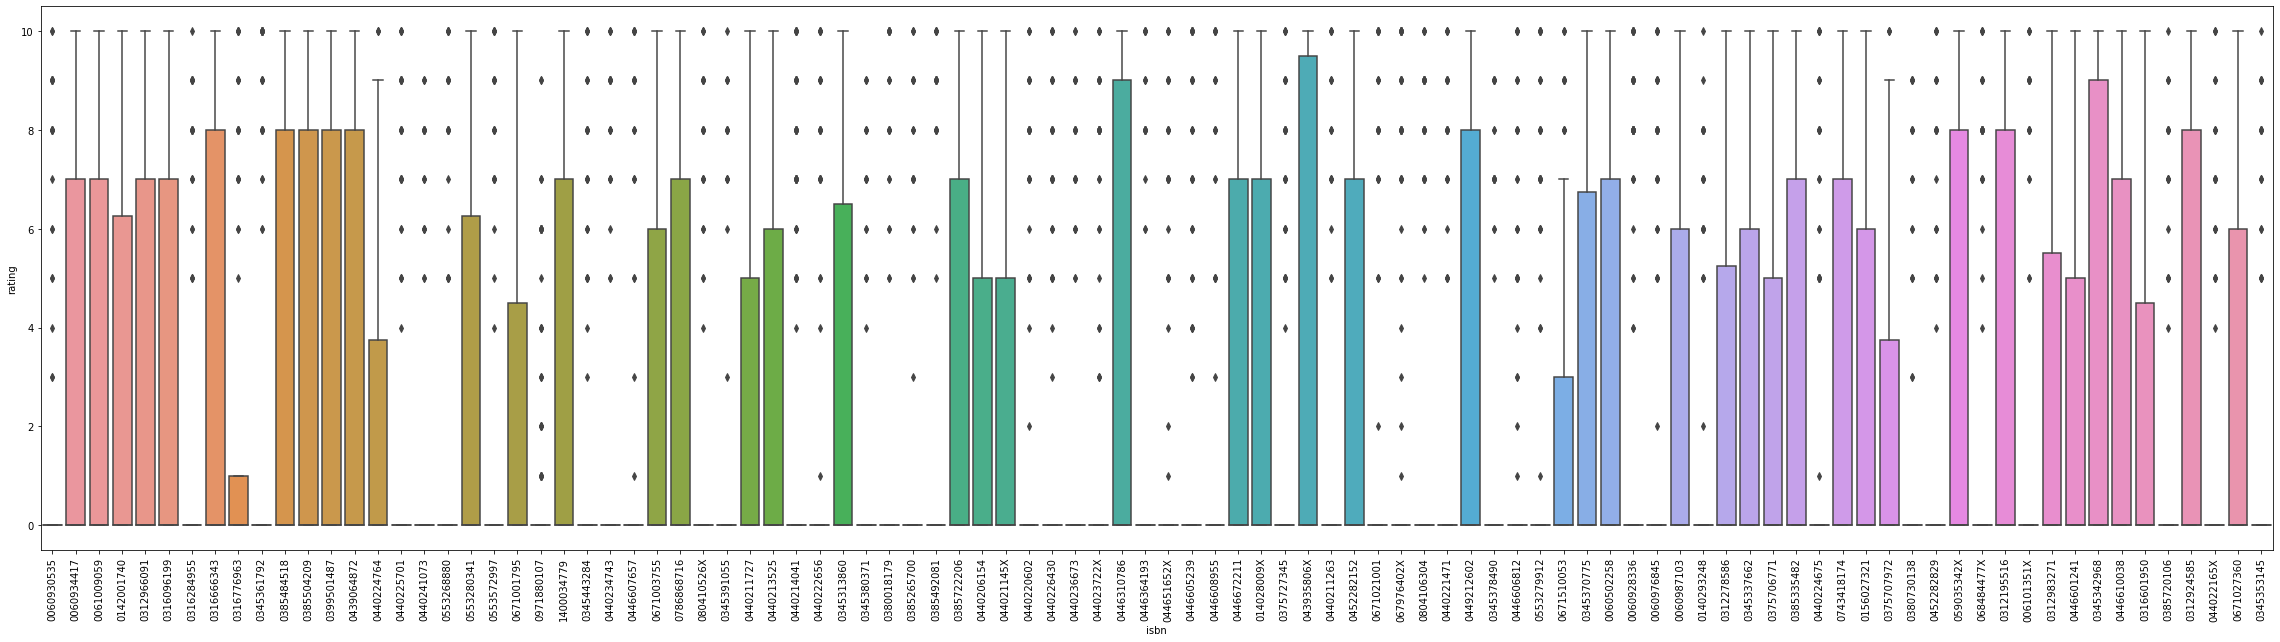

In [ ]:
plt.figure(figsize=(40,10))
chart = sns.boxplot(x='isbn',y='rating',data=df_final)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
plt.show()

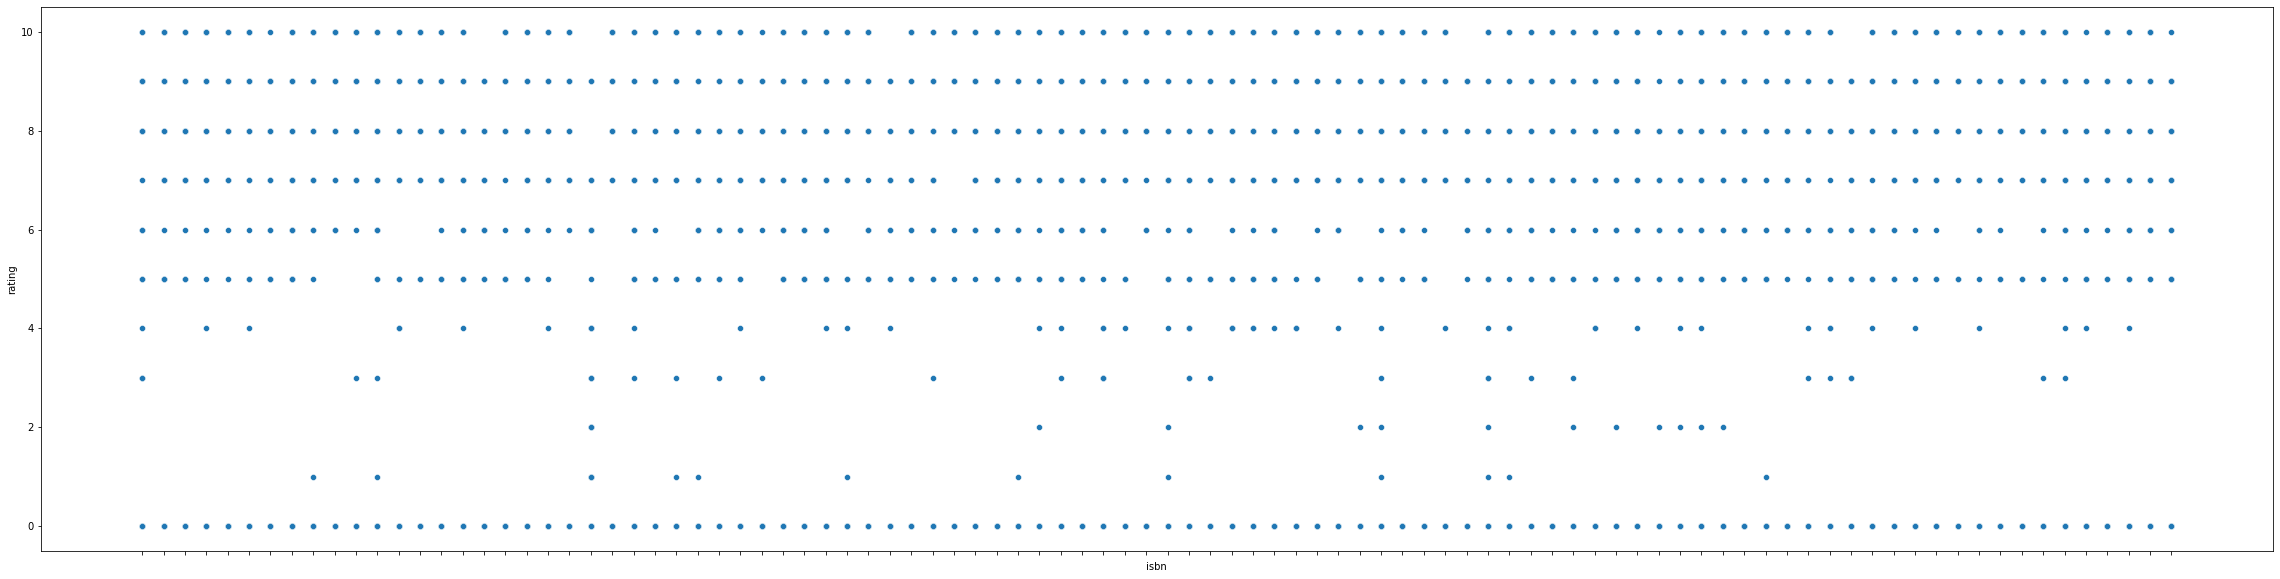

In [ ]:
plt.figure(figsize=(40,10))
chart_scatterplot = sns.scatterplot(x='isbn',y='rating',data=df_final)
chart_scatterplot.set_xticklabels(chart_scatterplot.get_xticklabels(), rotation=90)
plt.show()

# Preparing the data

## Creating the pivot table

In [ ]:
df_pivot_book = df_final.pivot(
                  index= "isbn",
                  columns='user',
                  values='rating')

## Cleaning the pivot table

In [ ]:
df_pivot_book = df_pivot_book.fillna(0)

## Creating the CSR Matrix

In [ ]:
csr_matrix_book = csr_matrix(df_pivot_book.values)

To create the Matrix we will use `csr_matrix` using the values of the pivot table 

# Creating the Model

In [ ]:
neighbours = NearestNeighbors(metric = 'cosine',n_neighbors=5, algorithm='auto')

## Training the model

In [ ]:
neighbours.fit(csr_matrix_book)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [ ]:
index_hashmap = list(df_pivot_book.index.values)
index_hashmap

# Recommendation function

In [ ]:
# function to return recommended books - this will be tested
def get_recommends(book = ""):
  book_isbn = "".join(set(df_final[df_final['title'] == book]['isbn'].values))
  index_book = index_hashmap.index(book_isbn)

  books_recommended = []
  og_book = book
  counter = 0
  distance, indeces = neighbours.kneighbors(csr_matrix_book[index_book,:])
  for index_, discance  in zip(indeces[0],distance[0]):
    if counter in [0]:
      counter +=1
      continue
    isbn =  index_hashmap[index_.item()]
    book_name = df_final[df_final['isbn']==isbn]['title'].values[0]
    book_distance = [book_name, discance]
    books_recommended.append(book_distance)
  recommended_books = [og_book,books_recommended]
  return recommended_books

Use the cell below to test your function. The `test_book_recommendation()` function will inform you if you passed the challenge or need to keep trying.

In [ ]:
books = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
print(books)

print('From here test')

def test_book_recommendation():
  test_pass = True
  recommends = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
  if recommends[0] != "Where the Heart Is (Oprah's Book Club (Paperback))":
    test_pass = False
  recommended_books = ["I'll Be Seeing You", 'The Weight of Water', 'The Surgeon', 'I Know This Much Is True']
  recommended_books_dist = [0.8, 0.77, 0.77, 0.77]
  for i in range(2): 
    if recommends[1][i][0] not in recommended_books:
      test_pass = False
    if abs(recommends[1][i][1] - recommended_books_dist[i]) >= 0.05:
      test_pass = False
  if test_pass:
    print("You passed the challenge! 🎉🎉🎉🎉🎉")
  else:
    print("You havn't passed yet. Keep trying!")

test_book_recommendation()

["Where the Heart Is (Oprah's Book Club (Paperback))", [['The Lovely Bones: A Novel', 0.7230184], ["The Pilot's Wife : A Novel", 0.81926787], ['The Joy Luck Club', 0.81986046], ['The Notebook', 0.823043]]]
From here test
You havn't passed yet. Keep trying!
